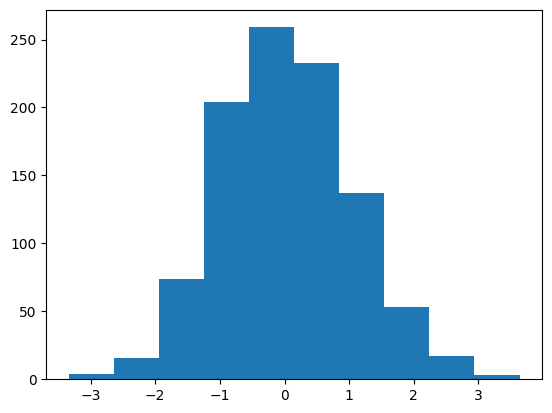

Files already downloaded and verified
162770
(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x21361B662D0>, tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]))
<class 'tuple'>


(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>,
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]))

In [3]:
from torch import normal
from torch import tensor
from torchvision import datasets
import matplotlib.pyplot as plt
from IPython.display import display
mean=0
std=1

samples=normal(mean, std, size=(1, 1000))

plt.hist(samples)
plt.show()

celebs=datasets.CelebA(root='./celeb/', download=True)

print(len(celebs))

print(celebs[0])
print(type(celebs[0]))
display(celebs[0])

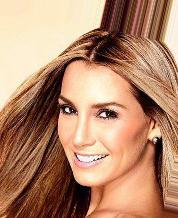

In [4]:
celebs[0][0]

In [5]:
# tensor of feature attributes
celebs[0][1]

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [6]:
import torch
im=celebs[0][0]

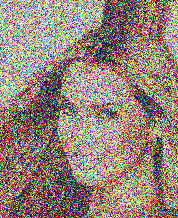

In [70]:
pixels=im.load()
for k in range(10):
    for i in range(im.size[0]):
        for j in range(im.size[1]):
            new_color=normal(tensor(pixels[i,j], dtype=torch.float),tensor((40,40,40), dtype=torch.float)).tolist()
            new_color=tuple([round(x) for x in new_color])
            im.putpixel((i,j),new_color)
im


In [12]:
from math import sqrt
def add_noise(image, var):
    pixels=image.load()
    for i in range(image.size[0]):
        for j in range(image.size[1]):
            new_color=normal(tensor([sqrt(1-var)*x for x in pixels[i,j]], dtype=torch.float),tensor((var*255, var*255, var*255), dtype=torch.float)).tolist()
            new_color=tuple([round(x) for x in new_color])
            im.putpixel((i,j),new_color)
    return image

In [30]:
im=celebs[0][0]

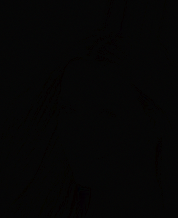

In [31]:
for i in range(100):
    im=add_noise(im, 0.1)
im